In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier
from sklearn.externals import joblib
from sklearn.preprocessing import RobustScaler

In [16]:
#best parameters- 'clip_weight': 20, 'learning_rate': 0.5, 'n_estimators': 800, 'subsample': 0.8, 
#'reg_lambda': 2, 'max_depth': 10

features = ['hh_m','hh_pt', 'hh_eta','hgg_pt_hh_m','hbb_pt_hh_m','cos_theta_cs','cos_theta_hbb','cos_theta_hgg']
features+=['leadJet_pt','leadJet_eta','subleadJet_pt','subleadJet_eta']
features+=['leadPho_pt','leadPho_eta','subleadPho_pt','subleadPho_eta']

scaler=RobustScaler()

In [17]:
#function for plotting the graphs
def plotting(y_pred,w_pred,y_truth,w_truth):
    fig=plt.figure(1)
    
    #plotting predicted histogram
    plt.subplot2grid((5,3),(0,0), rowspan=4,colspan=4)
    plt.hist(y_pred,weights=w_pred,bins=13,range=[-0.5,12.5],alpha=0.5,label='predicted histogram')
    
    #plotting truth histogram error
    htruth=np.histogram(y_truth,weights=w_truth,bins=13,range=[-0.5,12.5])
    htruth_e=np.histogram(y_truth,weights=w_truth**2,bins=13,range=[-0.5,12.5])
    err_y=np.sqrt(htruth_e[0])
    err_x=np.ones_like(htruth[0])*0.5
    x=np.arange(0,13,step=1)
    plt.errorbar(x,htruth[0],yerr=err_y,xerr=err_x,ecolor='black',elinewidth='0.5',fmt='none',label='$\sigma_{true}$')
    plt.legend()
    plt.ylabel('Events')
    plt.yscale('log')
    
    #plotting truth/pred plot 
    plt.subplot2grid((5,3),(4,0),rowspan=2,colspan=4)
    hpred=np.histogram(y_pred,weights=w_pred,bins=13,range=[-0.5,12.5])
    ratio=htruth[0]/hpred[0]
    plt.plot(x,ratio,'bo',markersize=2)
    plt.ylim(0.8,1.2)
    
    #plotting error in truth/pred plot
    err_y=np.sqrt(htruth_e[0])/hpred[0]
    err_x=np.ones_like(x)*0.5
    plt.errorbar(x,ratio,yerr=err_y,xerr=err_x,ecolor='black',elinewidth='0.5',fmt='none')
    plt.ylabel('true/pred')
    plt.xlabel('Category')
    
    #weighted least squares for truth/pred plot
    rsquare=(ratio-1)**2
    w=1./(err_y)**2
    weighted_least_squares=np.sum(np.multiply(rsquare,w))
    print "Weighted least squares: ",weighted_least_squares
    
    fig.set_size_inches(7, 9)
    plt.show()
    plt.close()

CPU times: user 3min 23s, sys: 6.44 s, total: 3min 30s
Wall time: 26.4 s
Weighted least squares:  17.8059


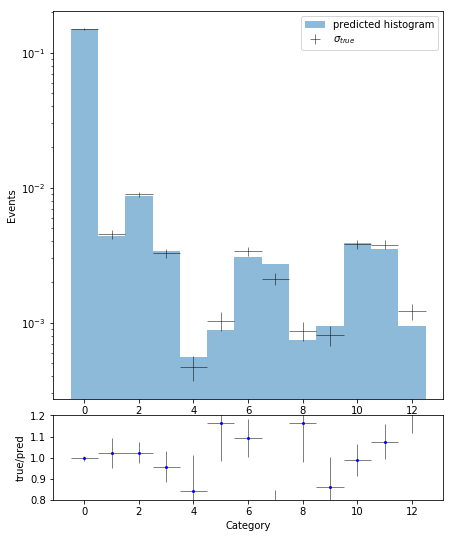

In [18]:
#node_box
df=pd.read_hdf("node_box.hd5")
X = df[features]
y = df['cat'] 
w = df['weight']

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#reweighting and clipping it at optimum 
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train]

clf=XGBClassifier(max_depth=10, n_estimators=800, n_jobs=8, objective='multi:softmax', subsample=0.8,
                 reg_lambda=2, learning_rate=0.5)
%time clf.fit(X_train,y_train,w_train)

#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

CPU times: user 3min 27s, sys: 5.1 s, total: 3min 32s
Wall time: 26.6 s
Weighted least squares:  22.2384


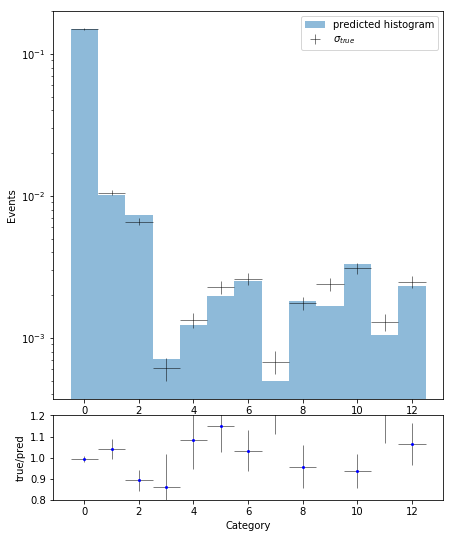

In [19]:
#node_2
df=pd.read_hdf("node_2.hd5")
X = df[features]
y = df['cat'] 
w = df['weight']

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#reweighting and clipping it at optimum 
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train]

clf=XGBClassifier(max_depth=10, n_estimators=800, n_jobs=8, objective='multi:softmax', subsample=0.8,
                 reg_lambda=2, learning_rate=0.5)
%time clf.fit(X_train,y_train,w_train)

#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

CPU times: user 2min 47s, sys: 3.68 s, total: 2min 51s
Wall time: 21.5 s
Weighted least squares:  18.9703


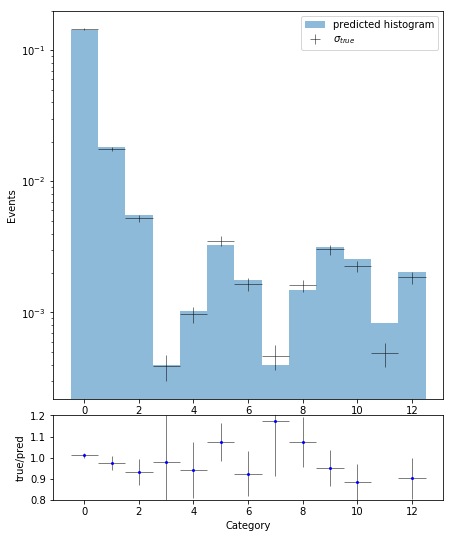

In [20]:
#node_3
df=pd.read_hdf("node_3.hd5")
X = df[features]
y = df['cat'] 
w = df['weight']

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#reweighting and clipping it at optimum 
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train]

clf=XGBClassifier(max_depth=10, n_estimators=800, n_jobs=8, objective='multi:softmax', subsample=0.8,
                 reg_lambda=2, learning_rate=0.5)
%time clf.fit(X_train,y_train,w_train)

#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

CPU times: user 2min 45s, sys: 3.97 s, total: 2min 49s
Wall time: 21.2 s
Weighted least squares:  15.6831


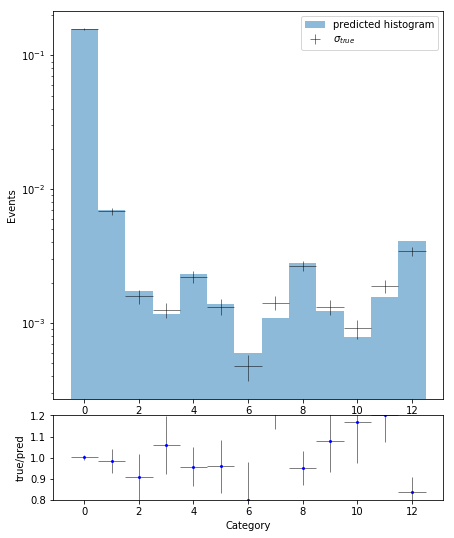

In [21]:
#node_5
df=pd.read_hdf("node_5.hd5")
X = df[features]
y = df['cat'] 
w = df['weight']

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#reweighting and clipping it at optimum 
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train]

clf=XGBClassifier(max_depth=10, n_estimators=800, n_jobs=8, objective='multi:softmax', subsample=0.8,
                 reg_lambda=2, learning_rate=0.5)
%time clf.fit(X_train,y_train,w_train)

#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

CPU times: user 2min 45s, sys: 3.6 s, total: 2min 48s
Wall time: 21.1 s
Weighted least squares:  16.4441


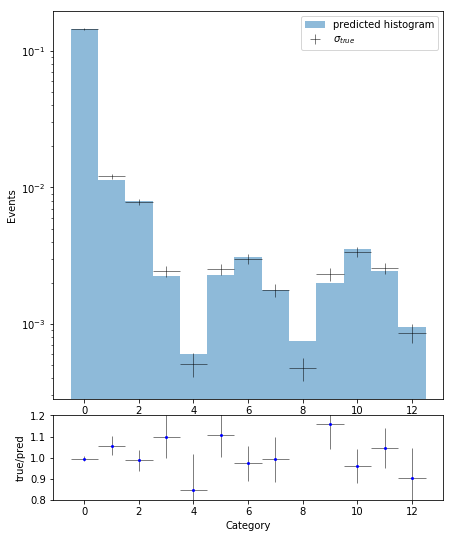

In [22]:
#node_7
df=pd.read_hdf("node_7.hd5")
X = df[features]
y = df['cat'] 
w = df['weight']

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#reweighting and clipping it at optimum 
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train]

clf=XGBClassifier(max_depth=10, n_estimators=800, n_jobs=8, objective='multi:softmax', subsample=0.8,
                 reg_lambda=2, learning_rate=0.5)
%time clf.fit(X_train,y_train,w_train)

#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

CPU times: user 2min 49s, sys: 3.81 s, total: 2min 52s
Wall time: 21.6 s
Weighted least squares:  19.9552


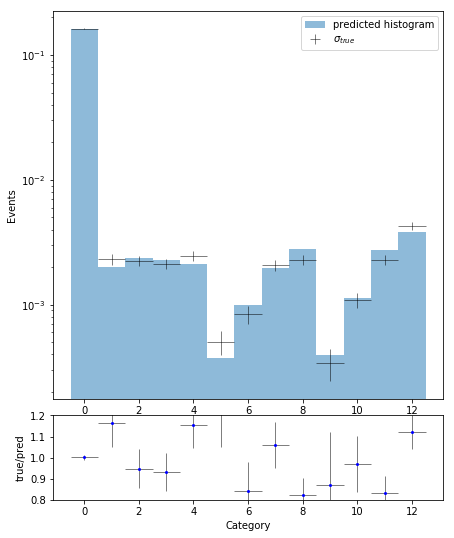

In [23]:
#node_8
df=pd.read_hdf("node_8.hd5")
X = df[features]
y = df['cat'] 
w = df['weight']

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#reweighting and clipping it at optimum 
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train]

clf=XGBClassifier(max_depth=10, n_estimators=800, n_jobs=8, objective='multi:softmax', subsample=0.8,
                 reg_lambda=2, learning_rate=0.5)
%time clf.fit(X_train,y_train,w_train)

#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

CPU times: user 2min 42s, sys: 4.05 s, total: 2min 46s
Wall time: 20.8 s
Weighted least squares:  13.8539


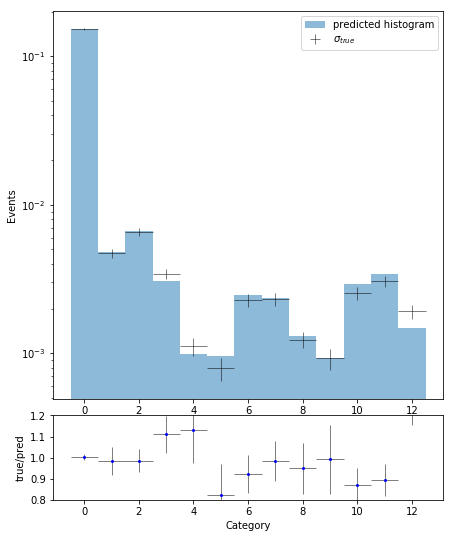

In [24]:
#node_10
df=pd.read_hdf("node_10.hd5")
X = df[features]
y = df['cat'] 
w = df['weight']

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#reweighting and clipping it at optimum 
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train]

clf=XGBClassifier(max_depth=10, n_estimators=800, n_jobs=8, objective='multi:softmax', subsample=0.8,
                 reg_lambda=2, learning_rate=0.5)
%time clf.fit(X_train,y_train,w_train)

#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

CPU times: user 2min 41s, sys: 5.15 s, total: 2min 46s
Wall time: 20.8 s
Weighted least squares:  11.4214


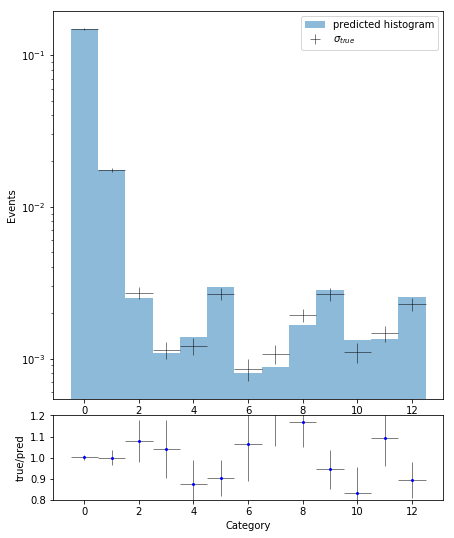

In [25]:
#node_11
df=pd.read_hdf("node_11.hd5")
X = df[features]
y = df['cat'] 
w = df['weight']

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#reweighting and clipping it at optimum 
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train]

clf=XGBClassifier(max_depth=10, n_estimators=800, n_jobs=8, objective='multi:softmax', subsample=0.8,
                 reg_lambda=2, learning_rate=0.5)
%time clf.fit(X_train,y_train,w_train)

#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

CPU times: user 2min 40s, sys: 3.82 s, total: 2min 44s
Wall time: 20.6 s
Weighted least squares:  13.1845


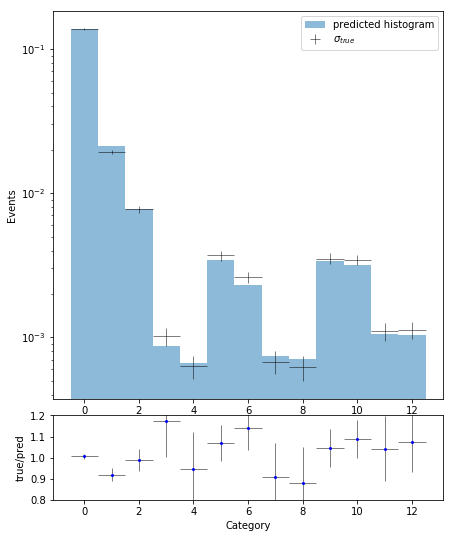

In [26]:
#node_12
df=pd.read_hdf("node_12.hd5")
X = df[features]
y = df['cat'] 
w = df['weight']

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#reweighting and clipping it at optimum 
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train]

clf=XGBClassifier(max_depth=10, n_estimators=800, n_jobs=8, objective='multi:softmax', subsample=0.8,
                 reg_lambda=2, learning_rate=0.5)
%time clf.fit(X_train,y_train,w_train)

#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

CPU times: user 2min 43s, sys: 3.85 s, total: 2min 47s
Wall time: 20.9 s
Weighted least squares:  7.64464


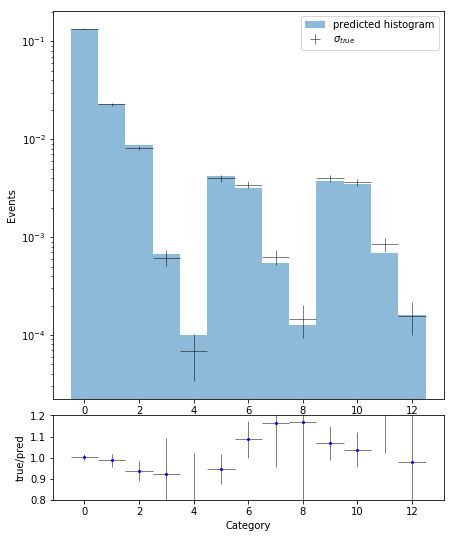

In [27]:
#node_13
df=pd.read_hdf("node_13.hd5")
X = df[features]
y = df['cat'] 
w = df['weight']

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#reweighting and clipping it at optimum 
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train]

clf=XGBClassifier(max_depth=10, n_estimators=800, n_jobs=8, objective='multi:softmax', subsample=0.8,
                 reg_lambda=2, learning_rate=0.5)
%time clf.fit(X_train,y_train,w_train)

#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)